# Project Overview

This notebook assumes that the reader has read the README.

In [61]:
import numpy as np
import uproot
import pandas as pd
import matplotlib.pyplot as plt

import os

# Preface with parameter(s)
plt.rcParams.update({'font.size': 12})

# given "uproot_io.py" at the start of the project to help handle files
from UG_Project_Raw.uproot_io import Events, View

In [62]:
# A non-corrupt copy of the cheated_0 file from the raw folder
events = Events("CheatedRecoFile_0_new.root")

# The Monte-Carlo PDG is a universel numbering scheme for all particles
# This dictionary was created by cross-referencing np.unique(events.mc_pdg) with the pdg codes
# !! no connection right now, find link to the paper
from pdgs import mc_pdg_dict # <- see "pdgs.py" for the full dictionary

## Examples

Here we have some example plots:
1. Example event with a characteristic track and shower.
2. Example event that exhibits the energy deposition through the ADCs, including scaling between an ADC and MeVs.
3. Typical workflow behind engineering a feature

### 1. Example event

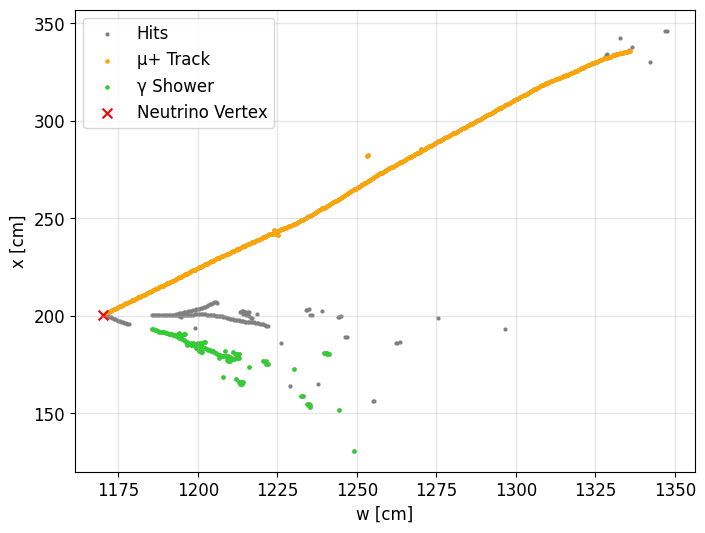

In [63]:
# Example event, with a characteristic track and shower
def plot_event(events, event_number):
    # Since each "event.number" isn't unique, 
    # Event numbers repeat after a threshold (I believe something like
    # 1, 2, ..., 98, 99, 0, 1, ...)
    # We need to split along each event number
    # This is what we call "identifiers"
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]

    # Abort if the event is too small
    if event_indices.size < 3:
        print(f"Event {event_number} too small")
        return
    w_hits = np.concatenate(events.reco_hits_w[event_indices])
    x_hits = np.concatenate(events.reco_hits_x_w[event_indices])

    # Choose the indices SPECIFICALLY in the case of event no.65
    # => not every event has tracks at [1] and [10]
    w_track = events.reco_hits_w[event_indices[1]]
    x_track = events.reco_hits_x_w[event_indices[1]]

    w_shower = events.reco_hits_w[event_indices[10]]
    x_shower = events.reco_hits_x_w[event_indices[10]]

    pdg_track = events.mc_pdg[event_indices[1]]
    pdg_shower = events.mc_pdg[event_indices[10]]

    plt.figure(figsize = (8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.scatter(w_hits, x_hits, s=4, c='grey', label='Hits')
    plt.scatter(w_track, x_track, s=5, c='orange', label=f'{mc_pdg_dict[pdg_track]} Track')
    plt.scatter(w_shower, x_shower, s=5, c='limegreen', label=f'{mc_pdg_dict[pdg_shower]} Shower')
    plt.scatter(events.neutrino_vtx_w[event_indices[0]], events.neutrino_vtx_x[event_indices[0]], marker='x', s=50, c='#F00', label='Neutrino Vertex')
    plt.xlabel('w [cm]')
    plt.ylabel('x [cm]')
    plt.legend()
    plt.show()

# There are ~9500 events in "CheatedRecoFile_0_new.root", and
# event 65 gives a nice comparison of track and shower:
plot_event(events, 65)


### 2. Energy plot

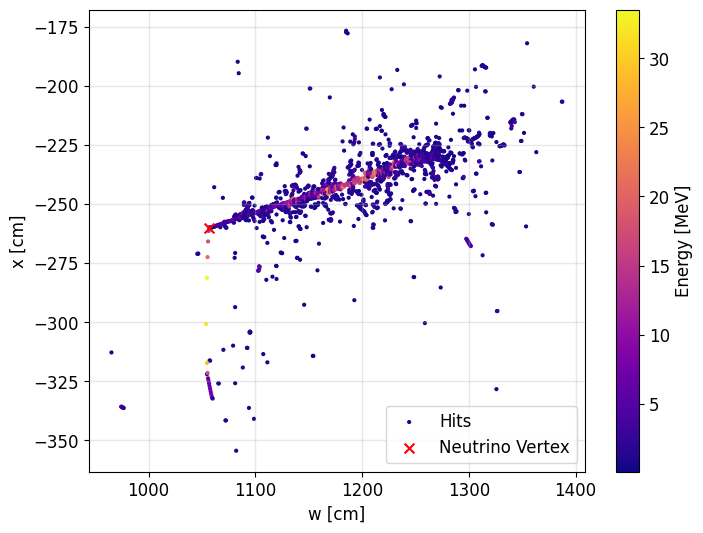

In [64]:
# Visual of the energy dispersion across an event
def plot_event_adc(events, event_number):
    identifiers = events.event_number
    change_indices = np.where(np.diff(identifiers) != 0)[0] + 1
    event_indices = np.split(np.arange(len(identifiers)), change_indices)[event_number]
    adcs = np.concatenate(events.reco_adcs_w[event_indices])
    adcs = 0.0075 * adcs # <- conversion between ADCs and MeVs

    if event_indices.size < 3:
        print(f"Event {event_number} too small")
        return
    
    # following two arrays are the event hits
    w_hits = np.concatenate(events.reco_hits_w[event_indices])
    x_hits = np.concatenate(events.reco_hits_x_w[event_indices])

    norm = plt.Normalize(vmin=np.min(adcs), vmax=np.max(adcs))
    cmap = plt.get_cmap('plasma')
    
    plt.figure(figsize = (8,6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    scatter = plt.scatter(w_hits, x_hits, s=4, c=adcs, cmap=cmap, label='Hits', norm=norm)
    plt.scatter(events.neutrino_vtx_w[event_indices[0]], events.neutrino_vtx_x[event_indices[0]], marker='x', s=50, c='#F00', label='Neutrino Vertex')
    plt.xlabel('w [cm]')
    plt.ylabel('x [cm]')
    plt.colorbar(scatter, label='Energy [MeV]')
    plt.legend()
    plt.show()

plot_event_adc(events, 1427) # <- another good example of an EM shower
# can see the characteristic spread as the decays both exponentiate and lose energy

### 3. Engineering a Feature

These features are highly motivated by the physics of the classification at hand. Here, we are looking at a track vs shower feature. Track-like particles usually present a path akin to an inert, undecaying line, whereas shower-like particles display a chaotic spread of cascading decays.

Hence, the hypothesis for finding the RMSE over a linear regression fit is that showers are likely to return a much higher RMSE than a track.

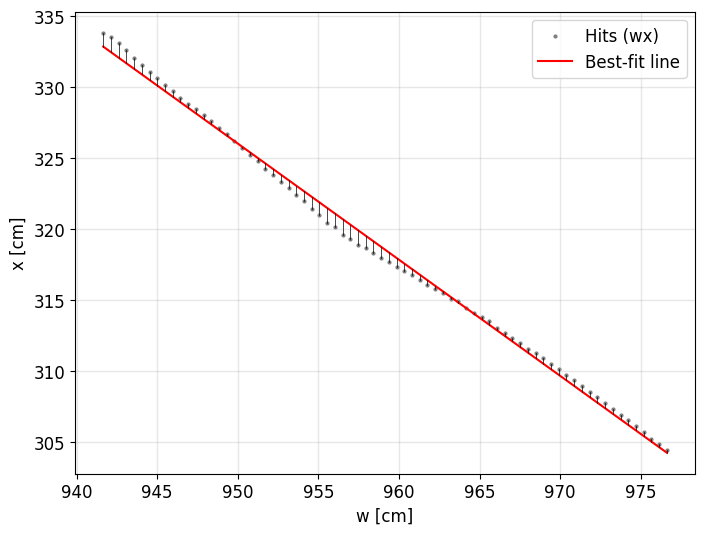

np.float64(0.5349399099832733)

In [65]:
# Example of engineering a track vs shower feature:
# Absolute RMSE

# In most of the raw code, there will be some confusion between what an event and particle is,
# typically "event_idx" <-> particle, and "event_number" <-> interaction
# This notebook will use a new, clearer convention:
# 1. "particle" for each individual particle in an event
# 2. "event" (or event_number) for each interaction

def rmse(events, particle, debug=False) -> float: # Returns our feature

    # RMSE is a spatial feature, so we get the coordinates
    w = np.array(events.reco_hits_w[particle])
    x = np.array(events.reco_hits_x_w[particle])

    # Throughout the project, we decided on a cutoff of 15 hits
    # For the study on an ideal cutoff number, refer to the final report II.J
    if len(w) < 15:
        if debug:
            print(f"Particle contains {len(w)} hit{"s" if len(w) > 1 else ""}, process aborted")
        return None # Since the particle hasn't met the cutoff

    # Find the line of best fit
    slope, intercept = np.polyfit(w, x, deg=1)
    x_bf = w * slope + intercept

    # Plot the demonstration
    if debug:
        plt.figure(figsize=(8,6))
        plt.scatter(w, x, c="grey", s=4, label="Hits (wx)")
        plt.plot(w, x_bf, c="r", label="Best-fit line")

        # Plot small lines for error
        for j in range(len(w)):
            plt.plot([w[j], w[j]], [x[j], x_bf[j]], c="k", linewidth=0.5)

        plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
        plt.xlabel('w [cm]')
        plt.ylabel('x [cm]')
        plt.legend()
        plt.show()

    # Return the RMSE of our particle
    return np.sqrt(np.mean((x - x_bf)**2))

# Example
rmse(events, 1, debug=True)

In [66]:
# This looks like a straight line, so I am going to predict that it is a track
# Print the PDG code of the second particle
print(events.mc_pdg[1])

13


PDG code $13$ corresponds to $\mu^-$, which is a track.

We can see that the feature is doing what we expect.

In [67]:
# Now that we have rmse(), we need to plot histograms to see if this feature is actually a good

track_rmse = []
shower_rmse = []

# Iterate over each particle in the file
N = len(events.num_final_state_particles) # <- number of particles in the event

# With reference to the notes, "showers" are defined as either electrons or photons
showers = {11, -11, 22} # pdg codes of electrons, positrons and photons

for idx in range(N):

    # Calculate the RMSE
    result = rmse(events, idx)

    # Sort into the correct list
    if events.mc_pdg[idx] in showers:
        shower_rmse.append(result)
    else:
        track_rmse.append(result)

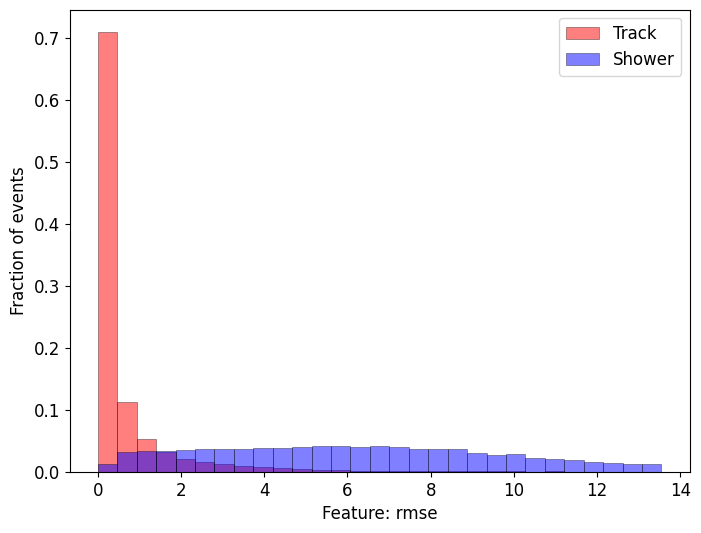

In [68]:
# Plot normalised histograms of track_rmse and shower_rmse

def track_shower_feature_histogram(events, feature_func, bins=30, show_percentile=95, debug=False):

    # Get the separate feature arrays (the same procedure as above)
    track_feature = []
    shower_feature = []

    N = len(events.num_final_state_particles)

    for idx in range(N):

        result = feature_func(events, idx)

        if result == None:
            continue
        elif events.mc_pdg[idx] in {-11, 11, 22}:
            shower_feature.append(result)
        else:
            track_feature.append(result)

    # Ensure numpy arrays, now we have the lists
    track_feature = np.array(track_feature)
    shower_feature = np.array(shower_feature)

    feature = np.append(track_feature, shower_feature)

    # Manually get the bin heights so that we can normalise
    Nt = len(track_feature)
    Ns = len(shower_feature)

    bin_edges = np.linspace(
        start=np.min(feature),
        stop=np.percentile(feature, show_percentile),
        num=bins
    )

    # Calculate fractional weights for each entry
    track_weights = np.ones_like(track_feature) / Nt if Nt > 0 else np.zeros_like(track_feature)
    shower_weights = np.ones_like(shower_feature) / Ns if Ns > 0 else np.zeros_like(shower_feature)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(track_feature, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(shower_feature, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(8, 6))
    plt.hist(
        track_feature,
        bins=bin_edges,
        weights=track_weights,
        color='r', edgecolor='k',
        linewidth=0.5,
        alpha=0.5,
        label='Track'
    )
    plt.hist(
        shower_feature,
        bins=bin_edges,
        weights=shower_weights,
        color='b',
        edgecolor='k',
        linewidth=0.5, 
        alpha=0.5,
        label='Shower'
    )
    plt.xlabel(f'Feature: {feature_func.__name__}')
    plt.ylabel('Fraction of events')
    plt.legend()
    plt.show()

    return track_bin_heights, shower_bin_heights

PDFs = track_shower_feature_histogram(events, rmse)


This gives a probability distribution function that we can use to assess a test particle.
1. Find the RMSE of a test particle.
2. Compare this RMSE with the PDF we gathered from the histogram above.
3. The probability of a: $$ P_\text{track/shower} = \frac{p_\text{track/shower}}{p_\text{track} + p_\text{shower}} $$ where $p$ are readings from the probability distribution, and $P$ is the resultant probability of each class.